In [78]:
#import all neccesary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import TimeSeriesSplit 
from scipy.optimize import minimize  
import warnings            
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from itertools import product    
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In this notebook we are going to predict metro (MRT) interstate. First of all, download the data using the link: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume. We are going to use only 4 features: Traffic Volume (our target feature), date_time, holiday and temp (temperature). 

In [2]:
#import data
data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
data = data[['traffic_volume', 'date_time','holiday','temp']]
data

,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14
...,...,...,...,...
48199,3543,2018-09-30 19:00:00,None,283.45
48200,2781,2018-09-30 20:00:00,None,282.76
48201,2159,2018-09-30 21:00:00,None,282.73
48202,1450,2018-09-30 22:00:00,None,282.09


Let's check duplicates in this data. For this purpose we use dublicate function and set the keep parameter as False to make sure that these rows are dublicates

In [3]:
#duplicates in the data. We can see al least two rows with the same values
data[data.duplicated(keep=False)==True]

,traffic_volume,date_time,holiday,temp
178,6793,2012-10-10 07:00:00,None,281.25
179,6793,2012-10-10 07:00:00,None,281.25
180,6283,2012-10-10 08:00:00,None,280.10
181,6283,2012-10-10 08:00:00,None,280.10
182,5680,2012-10-10 09:00:00,None,279.61
...,...,...,...,...
48173,3818,2018-09-29 19:00:00,None,280.68
48192,4380,2018-09-30 14:00:00,None,283.48
48193,4380,2018-09-30 14:00:00,None,283.48
48194,4302,2018-09-30 15:00:00,None,283.84


Okay, now we should remove the following rows (Save only one row from each dublicate sets)

In [4]:
#drop all duplicates. Keep only the first rows from the same ones
data.drop_duplicates(keep='first', inplace = True)
data.shape

(40653, 4)

## EDA

##### Date Time

In [5]:
#check the type of date_time column. It's str. We will fix it later
type(data['date_time'][0])

str

In [6]:
#Information about the date_time column. count is not equal to unique. Figure out this issue  
data['date_time'].describe()

count                   40653
unique                  40575
top       2016-05-28 14:00:00
freq                        2
Name: date_time, dtype: object

In [7]:
#Indeed, two string are not duplicates (vlalues from the temp column are different). 
data[data['date_time']=='2016-07-12 18:00:00']

,traffic_volume,date_time,holiday,temp
24899,4051,2016-07-12 18:00:00,None,301.38
24900,4051,2016-07-12 18:00:00,None,301.48


In [8]:
#Remove all duplicates in terms of date_time column
data.drop_duplicates(subset = ['date_time'], keep='first', inplace = True)

In [9]:
#Now it's okay
data['date_time'].describe()

count                   40575
unique                  40575
top       2016-11-07 01:00:00
freq                        1
Name: date_time, dtype: object

In [10]:
# Convert type of the column into the datetime type
data['date_time'] = data['date_time'].astype('datetime64[ns]')
type(data['date_time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:
# find the minimum time and the maximum time
min_time = data['date_time'].min()
max_time = data['date_time'].max()
min_time, max_time

(Timestamp('2012-10-02 09:00:00'), Timestamp('2018-09-30 23:00:00'))

In [12]:
# get all times from the minimum time to the maximum time with the time step 1 hour
range_time = pd.date_range(start=min_time, end=max_time, freq="H")
len(range_time)

52551

In [13]:
#convert traffic_volume column into float64 type. It is neccessary to interpolate
data['traffic_volume'] = data['traffic_volume'].astype('float64')

In [14]:
#add rows corresponding to the missing times in our data
for i in range_time:
    if  len(data[data["date_time"] == i]) == 0:
        data = data.append({"date_time": i},ignore_index=True)

In [15]:
#reindex our data to make indexes increasing with step 1
data = data.sort_values('date_time')
data[''] = range(data.shape[0])
data = data.set_index('')

In [16]:
#interpolate
data = data.interpolate(method = 'linear')
empty_holidays = data[data['holiday'].isna()==True]
empty_holidays

,traffic_volume,date_time,holiday,temp
,,,,
22,6092.000000,2012-10-03 07:00:00,NaN,278.175000
25,5346.333333,2012-10-03 10:00:00,NaN,285.643333
26,5221.666667,2012-10-03 11:00:00,NaN,288.806667
32,5380.000000,2012-10-03 17:00:00,NaN,294.395000
65,378.000000,2012-10-05 02:00:00,NaN,289.860000
...,...,...,...,...
49649,638.000000,2018-06-02 02:00:00,NaN,289.655000
51238,5464.500000,2018-08-07 07:00:00,NaN,292.407750
51239,5115.000000,2018-08-07 08:00:00,NaN,294.265500


In [17]:
#if we have missing holiday we can find row with the same day and take value of holiday from the row and fill missing 
#data with the obtained value
for i in empty_holidays.iterrows():
    
    this_day = data[(data['date_time'] >= pd.Timestamp(i[1]['date_time'].year, 
                                                       i[1]['date_time'].month, i[1]['date_time'].day, 0)) &
                   (data['date_time'] <= pd.Timestamp(i[1]['date_time'].year, i[1]['date_time'].month, 
                                                        i[1]['date_time'].day, 23))]
    
    for j in this_day['holiday']:
        if not j is np.nan:
            index = i[0]
            data.loc[index,'holiday'] = j
            break
    

empty_holidays = data[data['holiday'].isna()==True]

In [18]:
#Have a look at all possible public holidays
data['holiday'].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day', nan,
       'Martin Luther King Jr Day'], dtype=object)

In [19]:
#Functions that detemine if a day is public holiday or not
def is_New_Years_Day(date):
    years = [2012, 2013, 2014, 2015, 2016, 2017,2018]
    for i in range(len(years)):
        if (date.day == 1)&(date.month == 1)&(date.year == years[i]):
            return True
    return False

def is_Martin_Luther_King_Jr_Day(date):
    days = [16, 21, 20, 19, 18, 16, 15]
    years = [2012, 2013, 2014, 2015, 2016, 2017,2018]
    for i in range(len(years)):
        if (date.day == days[i])&(date.month == 1)&(date.year == years[i]):
            return True
    return False

def is_Washingtons_Birthday(date):
    days = [20,18,17,16,15,20,19]
    years = [2012, 2013, 2014, 2015, 2016, 2017,2018]
    for i in range(len(years)):
        if (date.day == days[i])&(date.month == 2)&(date.year == years[i]):
            return True
    return False

def is_Memorial_Day(date):
    days = [28,27,26,25,30,29,28]
    years = [2012, 2013, 2014, 2015, 2016, 2017,2018]
    for i in range(len(years)):
        if (date.day == 24)&(date.month == 5)&(date.year == years[i]):
            return True
    return False

def is_Independence_Day(date):
    years = [2012, 2013, 2014, 2015, 2016, 2017,2018]
    for i in range(len(years)):
        if (date.day == 4)&(date.month == 7)&(date.year == years[i]):
            return True
    return False

def is_Labor_Day(date):
    days = [3,2,1,7,5,4,3]
    years = [2012, 2013, 2014, 2015, 2016, 2017,2018]
    for i in range(len(years)):
        if (date.day == days[i])&(date.month == 9)&(date.year == years[i]):
            return True
    return False

def is_Columbus_Day(date):
    days = [8, 14, 13, 12, 10, 9,8]
    years = [2012, 2013, 2014, 2015, 2016, 2017,2018]
    for i in range(len(days)):
        if (date.day == days[i])&(date.month == 10)&(date.year == years[i]):
            return True
    return False

def is_Veterans_Day(date):
    years = [2012, 2013, 2014, 2015, 2016, 2017,2018]
    for i in range(len(years)):
        if (date.day == 11)&(date.month == 11)&(date.year == years[i]):
            return True
    return False

def is_Thanksgiving_Day(date):
    days = [22,28,27,26,24,23,22]
    years = [2012, 2013, 2014, 2015, 2016, 2017,2018]
    for i in range(len(days)):
        if (date.day == days[i])&(date.month == 11)&(date.year == years[i]):
            return True
    return False

def is_Christmas_Day(date):
    years = [2012, 2013, 2014, 2015, 2016, 2017,2018]
    for i in range(len(years)):
        if (date.day == 24)&(date.month == 12)&(date.year == years[i]):
            return True
    return False

def is_State_Fair(date):
    years = date.year
    if years == 2012:
        if (date >= pd.Timestamp(2012,8, 23, 0))&(date < pd.Timestamp(2012,9, 3, 0)):
                                    return True
    if years == 2013:
        if (date >= pd.Timestamp(2013,8, 23, 0))&(date < pd.Timestamp(2013,9, 2, 0)):
                                    return True
    if years == 2014:
        if (date >= pd.Timestamp(2014,8, 21, 0))&(date < pd.Timestamp(2014,9, 1, 0)):
                                    return True
    if years == 2015:
        if (date >= pd.Timestamp(2015,8, 27, 0))&(date < pd.Timestamp(2015,9, 7, 0)):
                                    return True
    if years == 2016:
        if (date >= pd.Timestamp(2016,8, 25, 0))&(date < pd.Timestamp(2016,9, 5, 0)):
                                    return True
    if years == 2017:
        if (date >= pd.Timestamp(2017,8, 24, 0))&(date < pd.Timestamp(2017,9, 4, 0)):
                                    return True
    if years == 2018:
        if (date >= pd.Timestamp(2018,8, 23, 0))&(date < pd.Timestamp(2018,9, 3, 0)):
                                    return True
    return False

In [20]:
#Fill missing values from holiday column. Checking all days is they are holidays or not 
for i in data.iterrows():
        if (pd.isnull(i[1]['holiday'])):
                if (is_New_Years_Day(i[1]['date_time'])):
                    data.loc[int(i[0]), 'holiday'] = 'New Years Day'

                elif (is_Martin_Luther_King_Jr_Day(i[1]['date_time'])):
                    data.loc[int(i[0]), 'holiday'] = 'Martin Luther King Jr Day'

                elif (is_Washingtons_Birthday(i[1]['date_time'])):
                    data.loc[int(i[0]), 'holiday'] = 'Washingtons Birthday'

                elif (is_Memorial_Day(i[1]['date_time'])):
                    data.loc[int(i[0]), 'holiday'] = 'Memorial Day'

                elif (is_Independence_Day(i[1]['date_time'])):
                    data.loc[int(i[0]), 'holiday'] = 'Independence Day'

                elif (is_Labor_Day(i[1]['date_time'])):
                    data.loc[int(i[0]), 'holiday'] = 'Labor Day'

                elif (is_Columbus_Day(i[1]['date_time'])):
                    data.loc[int(i[0]), 'holiday'] = 'Columbus Day'



                elif (is_Veterans_Day(i[1]['date_time'])):
                    data.loc[int(i[0]), 'holiday'] = 'Veterans Day'
                elif (is_Thanksgiving_Day(i[1]['date_time'])):
                    data.loc[int(i[0]), 'holiday'] = 'Thanksgiving Day'
                elif (is_Christmas_Day(i[1]['date_time'])):
                    data.loc[int(i[0]), 'holiday'] = 'Christmas Day'
                elif (is_State_Fair(i[1]['date_time'])):
                    data.loc[int(i[0]), 'holiday'] = 'Labor Day'
                else:
                    data.loc[int(i[0]), 'holiday'] = 'None'
        

In [21]:
#Now we don't have missing values in the holiday column
empty_holidays = data[data['holiday'].isna()==True]
empty_holidays

,traffic_volume,date_time,holiday,temp
,,,,


##### Traffic Volume

In [22]:
#Checking empty values from the column
len(data[data['traffic_volume'].isna()==True])

0

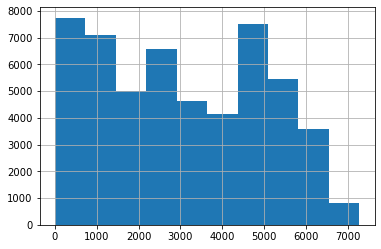

In [23]:
#Histogram of the data from the column. These values have the float type
data['traffic_volume'].hist()

In [24]:
#DEscribe the column
data['traffic_volume'].describe()

count    52551.000000
mean      3071.868385
std       1922.655704
min          0.000000
25%       1223.058955
50%       2896.500000
75%       4775.000000
max       7280.000000
Name: traffic_volume, dtype: float64

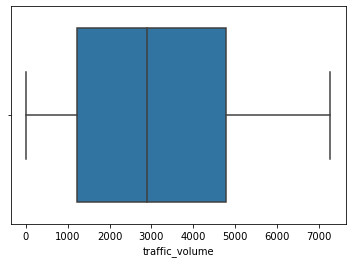

In [25]:
#Boxplot
sns.boxplot(x=data["traffic_volume"])

The target value is good. It does not contain any missed values or outliers

##### holiday

In [26]:
len(data[data['holiday'].isna()==True])

0

In [27]:
data['holiday'].describe()

count     52551
unique       12
top        None
freq      51949
Name: holiday, dtype: object

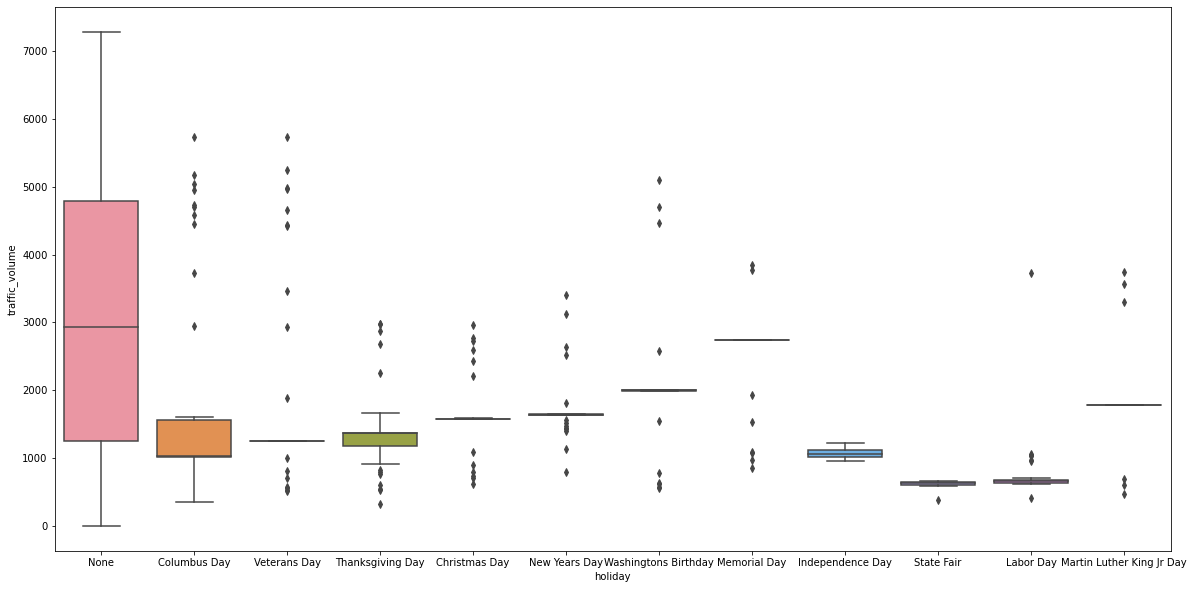

In [28]:
plt.figure(figsize=(20, 10))
sns.boxplot(y=data["traffic_volume"], x = data['holiday'])

We have different ranges for public holidays. It means that we can not unite the columns and should consider all of them as unique information about traffic_volume

In [29]:
holidays = pd.get_dummies(data.holiday)

In [30]:
data = pd.concat([data, holidays], axis = 1)

In [31]:
data.drop(['holiday'], axis = 1, inplace = True)

In [32]:
data

,traffic_volume,date_time,temp,Christmas Day,Columbus Day,Independence Day,Labor Day,Martin Luther King Jr Day,Memorial Day,New Years Day,None,State Fair,Thanksgiving Day,Veterans Day,Washingtons Birthday
,,,,,,,,,,,,,,,
0,5545.0,2012-10-02 09:00:00,288.28,0,0,0,0,0,0,0,1,0,0,0,0
1,4516.0,2012-10-02 10:00:00,289.36,0,0,0,0,0,0,0,1,0,0,0,0
2,4767.0,2012-10-02 11:00:00,289.58,0,0,0,0,0,0,0,1,0,0,0,0
3,5026.0,2012-10-02 12:00:00,290.13,0,0,0,0,0,0,0,1,0,0,0,0
4,4918.0,2012-10-02 13:00:00,291.14,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52546,3543.0,2018-09-30 19:00:00,283.45,0,0,0,0,0,0,0,1,0,0,0,0
52547,2781.0,2018-09-30 20:00:00,282.76,0,0,0,0,0,0,0,1,0,0,0,0
52548,2159.0,2018-09-30 21:00:00,282.73,0,0,0,0,0,0,0,1,0,0,0,0


##### temp

In [33]:
len(data[data['temp'].isna()==True])

0

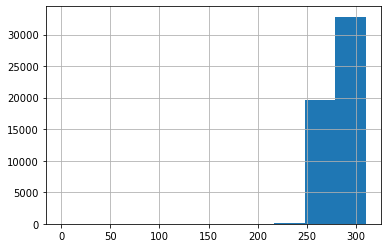

In [34]:
data['temp'].hist()

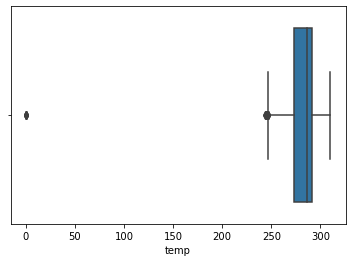

In [35]:
sns.boxplot(x=data["temp"])

In [36]:
data['temp'].describe()

count    52551.000000
mean       282.503180
std         12.991269
min          0.000000
25%        273.580000
50%        286.420000
75%        291.703441
max        310.070000
Name: temp, dtype: float64

Because the temperature values is from the Kelvin scale, it is impossible not have 0 values. Let's remove them and interpolate one more time

In [37]:
indexes = data[data['temp'] == 0].index
for i in indexes:
    data.loc[i,'temp'] = np.nan

In [38]:
len(data[data['temp'].isna()==True])

10

In [39]:
data = data.interpolate(method = 'linear')

In [40]:
len(data[data['temp'].isna()==True])

0

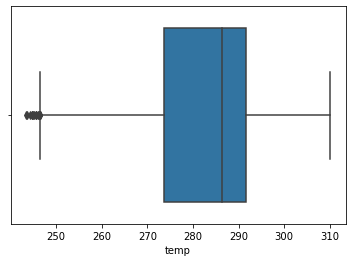

In [41]:
sns.boxplot(x=data["temp"])

In [42]:
#Our final data
data

,traffic_volume,date_time,temp,Christmas Day,Columbus Day,Independence Day,Labor Day,Martin Luther King Jr Day,Memorial Day,New Years Day,None,State Fair,Thanksgiving Day,Veterans Day,Washingtons Birthday
,,,,,,,,,,,,,,,
0,5545.0,2012-10-02 09:00:00,288.28,0,0,0,0,0,0,0,1,0,0,0,0
1,4516.0,2012-10-02 10:00:00,289.36,0,0,0,0,0,0,0,1,0,0,0,0
2,4767.0,2012-10-02 11:00:00,289.58,0,0,0,0,0,0,0,1,0,0,0,0
3,5026.0,2012-10-02 12:00:00,290.13,0,0,0,0,0,0,0,1,0,0,0,0
4,4918.0,2012-10-02 13:00:00,291.14,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52546,3543.0,2018-09-30 19:00:00,283.45,0,0,0,0,0,0,0,1,0,0,0,0
52547,2781.0,2018-09-30 20:00:00,282.76,0,0,0,0,0,0,0,1,0,0,0,0
52548,2159.0,2018-09-30 21:00:00,282.73,0,0,0,0,0,0,0,1,0,0,0,0


## Modelling

##### Test-train split

In [43]:
test = data[data['date_time'] >  data.date_time.max() - relativedelta(days=7)] 
train = data[data['date_time'] <=  data.date_time.max() - relativedelta(days=7)]

In [44]:
train.index = train.date_time
train = train.drop(['date_time'], axis=1)

In [45]:
test.index = test.date_time
test = test.drop(['date_time'], axis = 1)

##### Reduce number of the observations

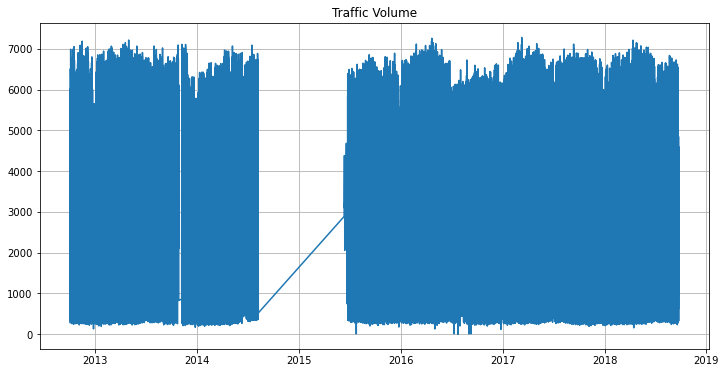

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(train.traffic_volume)
plt.title('Traffic Volume')
plt.grid(True)
plt.show()

It's strange, but a lot of data in 2015 is missed. I checked the dataset, it is missed indeed. Okay, Let's drop some observations

In [47]:
train = train[train.index > pd.Timestamp(2015, 6, 12, 0)]

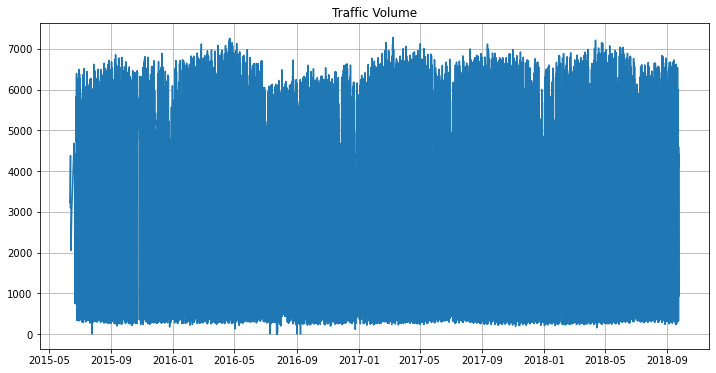

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(train.traffic_volume)
plt.title('Traffic Volume')
plt.grid(True)
plt.show()

In [49]:
def days_correlations():
    result = []
    for i in range(1190):
        list1 = train[train.index >= train.index.min() +  relativedelta(days=i)]['traffic_volume'].values
        list2 = train[train.index <= train.index.max() - relativedelta(days=i)]['traffic_volume'].values
        result.append(np.corrcoef(list1, list2)[0,1])
    return result

def weeks_correlation():
    result = []
    for i in range(170):
        list1 = train[train.index >= train.index.min() + relativedelta(weeks=i)]['traffic_volume'].values
        list2 = train[train.index <= train.index.max() - relativedelta(weeks=i)]['traffic_volume'].values
        result.append(np.corrcoef(list1, list2)[0,1])
    return result

In [50]:
corrs_d = days_correlations()
corrs_w = weeks_correlation()

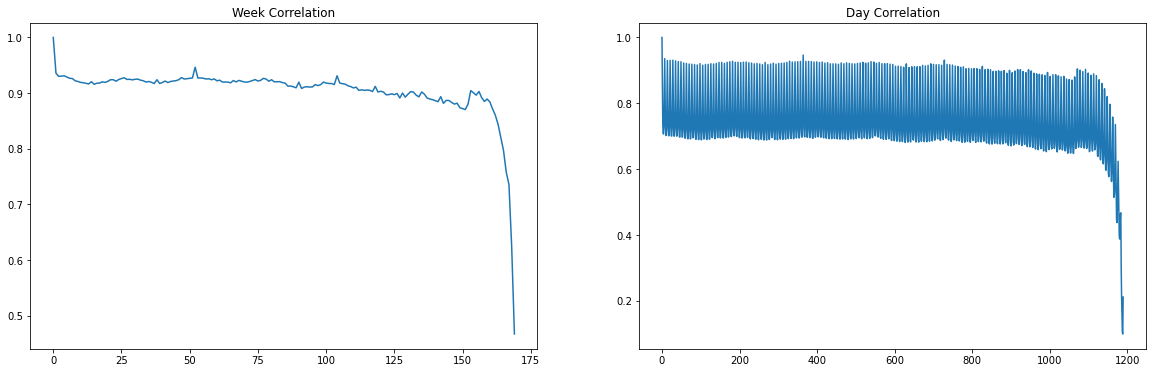

In [51]:
gridsize = (1, 2)
fig = plt.figure(figsize=(20, 6))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax1.plot(corrs_w)
ax2.plot(corrs_d)
ax1.set_title('Week Correlation')
ax2.set_title('Day Correlation')
plt.show()

In [52]:
train = train[train.index > train.index.max() -  relativedelta(weeks=150)]

We left a lot of data. But probably we will not use all of them to predict the futher 7 days. At least we can remove them later if we want

##### More features

In [53]:
train['weekday'] = train.index.dayofweek
test['weekday'] = test.index.dayofweek
train["hour"] = train.index.hour
test["hour"] = test.index.hour

##### Baseline forecast

In [54]:
groped = train.groupby(["weekday", "hour"])["traffic_volume"].mean()

In [55]:
y = test.traffic_volume.values
predict = []
for i in test.iterrows():
    predict.append(groped[i[1]['weekday'], i[1]['hour']])

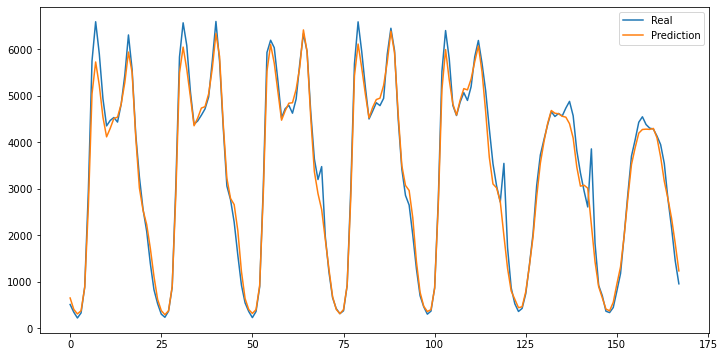

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.plot(predict)
plt.legend(['Real', 'Prediction'])
plt.show()

In [57]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [58]:
mean_absolute_percentage_error(y, predict)

8.038865621950595

##### Holt-Winter's Model

In [59]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [60]:


def timeseriesCVscore(params, series, loss_function=mean_absolute_percentage_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [61]:
%%time
data_HW =  train.traffic_volume 

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data_HW, mean_absolute_percentage_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.40076843239910653 0.0005028317895299783 0.037030238900877144
Wall time: 2min 25s


In [62]:
alpha_final

0.40076843239910653

In [63]:
model = HoltWinters(data_HW, slen = 168, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 168)
model.triple_exponential_smoothing()

In [64]:
prediction = model.result[-168:]

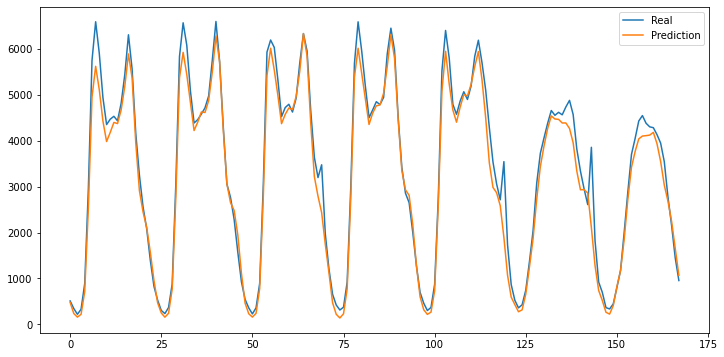

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.plot(prediction)
plt.legend(['Real', 'Prediction'])
plt.show()

In [66]:
mean_absolute_percentage_error(y, prediction)

11.187722185982718

Holt-Winnter's didn't show better than the beaseline model results 

##### ARIMA

In [67]:
len(test[test['None'] == 1]) == len(test)

True

There is no public holidays, therefore all days should have the same behavior like the others corresponding days of week

In [68]:
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 168

In [69]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [98]:
def optimizeSARIMA(parameters_list, d, D, s):
    
    results = []

    for param in tqdm_notebook(parameters_list):
        model=sm.tsa.statespace.SARIMAX(train[-504:].traffic_volume, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        results.append([param, model.aic])
    
    return results

#result = optimizeSARIMA(parameters_list, d, D, s)

In [99]:
#result

[[(2, 2, 0, 0), 4980.18752980836],
 [(2, 2, 0, 1), 4937.397003197411],
 [(2, 2, 1, 0), 4948.85058317889],
 [(2, 2, 1, 1), 4939.2175177505005],
 [(2, 3, 0, 0), 4981.66705719703],
 [(2, 3, 0, 1), 4935.273054659347],
 [(2, 3, 1, 0), 4936.095493078887],
 [(2, 3, 1, 1), 4947.722624639529],
 [(2, 4, 0, 0), 4969.941696997219],
 [(2, 4, 0, 1), 4932.559282357274],
 [(2, 4, 1, 0), 4933.720465337763],
 [(2, 4, 1, 1), 4934.466879220239],
 [(3, 2, 0, 0), 4981.326638963361],
 [(3, 2, 0, 1), 4936.166698585976],
 [(3, 2, 1, 0), 4936.883996245104],
 [(3, 2, 1, 1), 4938.799992211341],
 [(3, 3, 0, 0), 4978.152979938226],
 [(3, 3, 0, 1), 4939.662280061426],
 [(3, 3, 1, 0), 4940.458200115358],
 [(3, 3, 1, 1), 4941.6596828929105],
 [(3, 4, 0, 0), 4976.103021653715],
 [(3, 4, 0, 1), 4932.237446418736],
 [(3, 4, 1, 0), 4936.467272331944],
 [(3, 4, 1, 1), 4941.086691582526],
 [(4, 2, 0, 0), 4974.129525582581],
 [(4, 2, 0, 1), 4937.311585127307],
 [(4, 2, 1, 0), 4938.086882396554],
 [(4, 2, 1, 1), 4939.96276820

The best parameters are ps = 3, qs = 4, Ps = 0, Qs = 1

In [70]:
best_model=sm.tsa.statespace.SARIMAX(train[-504:].traffic_volume, order=(3, 1, 4), 
                                        seasonal_order=(0, 1, 1, 168)).fit(disp=-1)
print(best_model.summary())

                                       SARIMAX Results                                       
Dep. Variable:                        traffic_volume   No. Observations:                  504
Model:             SARIMAX(3, 1, 4)x(0, 1, [1], 168)   Log Likelihood               -2457.119
Date:                               Mon, 11 Jan 2021   AIC                           4932.237
Time:                                       13:42:43   BIC                           4966.565
Sample:                                   09-03-2018   HQIC                          4945.923
                                        - 09-23-2018                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8678      0.228      8.196      0.000       1.421       2.314
ar.L2      

In [71]:
forecast = best_model.get_forecast(steps=168)

In [83]:
y.min()

219.0

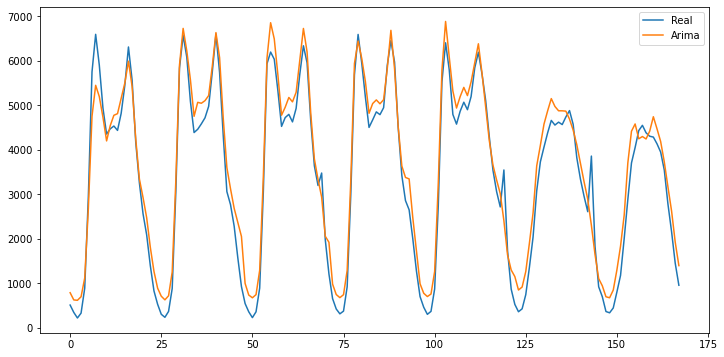

In [94]:
plt.figure(figsize=(12, 6))
plt.plot(test.traffic_volume.values)
plt.plot(forecast.predicted_mean.values)
plt.legend(['Real', 'Arima'])
plt.show()

In [95]:
mean_absolute_percentage_error(test.traffic_volume.values, forecast.predicted_mean.values)

28.241009682235262

It is very bad model. It calculates slow and the quality of prediction is low

##### Linear Regression

In [193]:
x_train = train[['weekday', 'hour', 'temp']]
y_train  = train.traffic_volume
x_test = test [['weekday', 'hour', 'temp']]
y_test = test.traffic_volume
x_train['lag_week'] = train.traffic_volume.shift(168)
x_train = x_train.dropna()
y_train = y_train[168:]
x_test['lag_week'] = train.traffic_volume[-168:].values

In [194]:
expected_train = []
expected_test = []
for i in x_train.iterrows():
    expected_train.append(groped[i[1]['weekday'],i[1]['hour']])
for i in x_test.iterrows():
    expected_test.append(groped[i[1]['weekday'],i[1]['hour']])
x_test['expected'] = expected_test
x_train['expected'] = expected_train

In [195]:
x_test['workday'] = (x_test['weekday']  != 5)&(x_test['weekday']  != 6)
x_test['workday'] = x_test['workday'].map({True:1, False:0})
x_train['workday'] = (x_train['weekday']  != 5)&(x_train['weekday']  != 6)
x_train['workday'] = x_train['workday'].map({True:1, False:0})
x_test = x_test.drop(['weekday'], axis=1)
x_train = x_train.drop(['weekday'], axis=1)

In [196]:
len(x_train) == len(y_train)

True

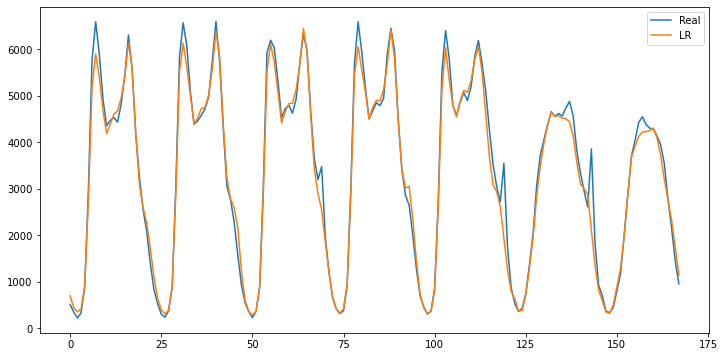

In [197]:
ss = StandardScaler()
ss = ss.fit(x_train)
x_train = ss.transform(x_train)
ss2 = StandardScaler()
ss2 = ss2.fit(x_test)
x_test = ss2.transform(x_test)
lr = LinearRegression().fit(x_train, y_train)
prediction = lr.predict(x_test)
plt.figure(figsize=(12, 6))
plt.plot(test.traffic_volume.values)
plt.plot(prediction)
plt.legend(['Real', 'LR'])
plt.show()

In [198]:
mean_absolute_percentage_error(test.traffic_volume.values, prediction)

7.650145072943575

In [199]:
lr.coef_

array([-4.42538271e+00,  4.74233138e+01,  3.45126274e+02,  1.55896134e+03,
        1.37864833e+00])

In [200]:
groped[0, 0]

648.8566666666667

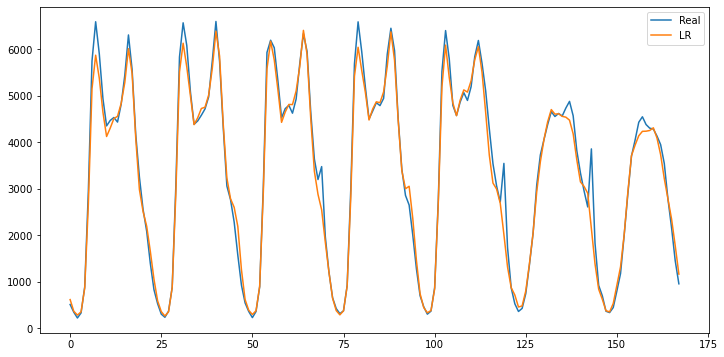

In [202]:
x_train = pd.DataFrame(x_train, columns = ['hour', 'temp', 'lag_week', 'expected', 'workday'])
x_test = pd. DataFrame(x_test, columns = ['hour', 'temp', 'lag_week', 'expected', 'workday'])
x_train = x_train.drop(['temp'], axis = 1)
x_test = x_test.drop(['temp'], axis = 1)
lr = LinearRegression().fit(x_train, y_train)
prediction = lr.predict(x_test)
plt.figure(figsize=(12, 6))
plt.plot(test.traffic_volume.values)
plt.plot(prediction)
plt.legend(['Real', 'LR'])
plt.show()

In [203]:
mean_absolute_percentage_error(test.traffic_volume.values, prediction)

7.073246311311852

Without temp column results are better, so we don't have to use ARIMA to evaluate temp for the next 2 weeks. Actually, i didn''t want

In [205]:
groped = train.groupby(["weekday", "hour"])["traffic_volume"].std()

In [211]:
values = groped.values

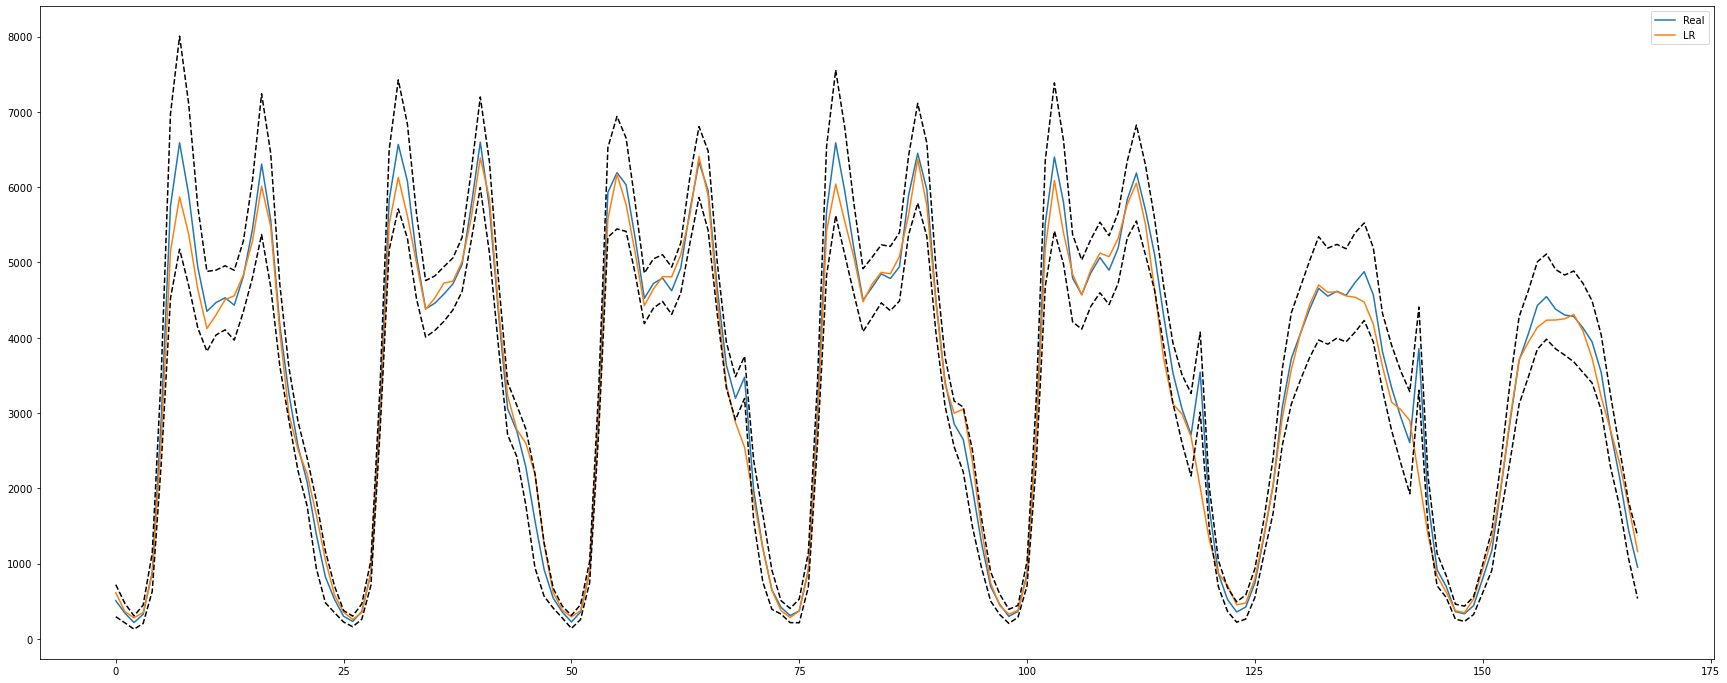

In [217]:
plt.figure(figsize=(30, 12))
plt.plot(test.traffic_volume.values)
plt.plot(prediction)
plt.plot(test.traffic_volume.values + values, color = 'black', linestyle = '--',)
plt.plot(test.traffic_volume.values - values, color = 'black', linestyle = '--',)
plt.legend(['Real', 'LR'])
plt.show()